## PS7 Yuming Liu

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.interpolate import LSQUnivariateSpline

import warnings
warnings.filterwarnings("ignore")

### Problem 1(a)

In [2]:
df = pd.read_csv('data/strongdrink.txt')

X = df[['alco','malic','tot_phen','color_int']]
y = df['cultivar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

result = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

Results = pd.DataFrame({"j = 1":np.append(result.intercept_[0],result.coef_[0]),
              "j = 2":np.append(result.intercept_[1],result.coef_[1])},
               index=["beta_0","beta_1",'beta_2','beta_3','beta_4'])
print(Results)

y_pred = result.predict(X_test) 

print(classification_report(y_test, y_pred))

            j = 1      j = 2
beta_0 -24.027617  22.780733
beta_1   1.701734  -1.466297
beta_2  -0.265788  -0.332951
beta_3   1.224101   0.663556
beta_4   0.022507  -0.922682
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



From the report, the error rates for the above groups are 13%, 0%, and 0%. Based on the f1-score, we have that $j=3$ is the best model for prediction.

In [3]:
MSE = (y_test != y_pred).mean()
print('The MSE from the test set is ', MSE)

The MSE from the test set is  0.045454545454545456


### Problem 1(b)

In [4]:
X = df[["alco","malic","tot_phen","color_int"]].values
y = df["cultivar"].values

N_loo = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE_vec = np.zeros(N_loo)

ypred = np.zeros(X.shape[0])

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    if y_test == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1

In [5]:
print(classification_report(y, ypred))
MSE_loo = MSE_vec.mean()
print('The estimate MSE loocv of the test =', MSE_loo)

              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176

The estimate MSE loocv of the test = 0.07954545454545454


From the report, the error rates for the above groups are 10%, 9%, and 4%. The rates are higher than those from (a). Based on the f1-score, we have that $j=3$ is the best model for prediction.


### Problem 1(c)

In [6]:
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(4)

k_ind = int(0)
ypred = np.zeros(X.shape[0])

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    k_ind += 1

In [7]:
MSE_kf = MSE_vec_kf.mean()
print(classification_report(y, ypred))
print('The estimate MSE loocv of the test =', MSE_kf)

              precision    recall  f1-score   support

           1       0.87      0.93      0.90        59
           2       0.91      0.87      0.89        71
           3       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176

The estimate MSE loocv of the test = 0.10795454545454546


From the report, the error rates for the above groups are 13%, 9%, and 4%. The rates of 2 and 3 are higher than those from (a). The rate of 1 is higher than which from (b). The rates of 2 and 3 are possiblely the same from (b). Based on the f1-score, we have that $j=3$ is the best model for prediction.


### Problem 2(a)

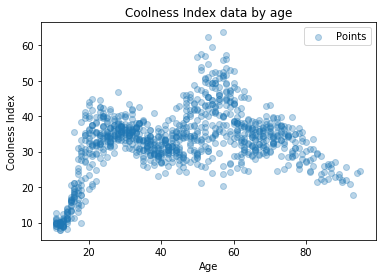

In [8]:
df2 = pd.read_csv("data/CoolIndex.txt",names=["Age","Cool"])

plt.scatter(x =df2['Age'], y =df2['Cool'], alpha=0.3, label="Points")
plt.title('Coolness Index data by age')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.show()

### Problem 2(b)

In [9]:
df2["bin1"]=np.where((df2.Age>=11) & (df2.Age<22),1,0)
df2["bin2"]=np.where((df2.Age>=22) & (df2.Age<40),1,0)
df2["bin3"]=np.where((df2.Age>=40) & (df2.Age<59),1,0)
df2["bin4"]=np.where((df2.Age>=59) & (df2.Age<77),1,0)
df2["bin5"]=np.where((df2.Age>=77) & (df2.Age<=95),1,0)

In [10]:
X = df2[["bin1", "bin2", "bin3", "bin4", "bin5"]]
y = df2['Cool']
res = sm.OLS(y, X, missing='drop').fit()

In [11]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        15:25:31   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.0

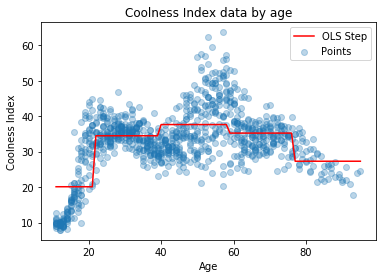

In [12]:
plt.scatter(df2['Age'], df2['Cool'], alpha=0.3, label='Points')
plt.plot(df2['Age'], res.predict(), 'r', label='OLS Step')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index data by age')
plt.show()

In [13]:
print('The predicted coolness of a 73-year old from the step function is', res.params[3])

The predicted coolness of a 73-year old from the step function is 35.22540004024275


### Problem 2(c)

In [14]:
df3 = df2.groupby('Age').mean()
df3['Age']=df3.index

In [15]:
lsq = LSQUnivariateSpline(np.array(df3['Age']), np.array(df3['Cool']), t = [22,40,59,77], k = 1)

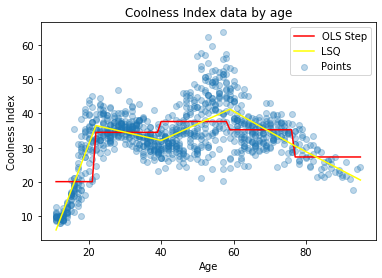

In [16]:
plt.scatter(df2['Age'], df2['Cool'], alpha=0.3, label='Points')
plt.plot(df2['Age'], res.predict(), 'r', label='OLS Step')
plt.plot(df3['Age'], lsq(df3['Age']), 'yellow', label='LSQ')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index data by age')
plt.show()

In [17]:
print('The predicted coolness of a 73-year old from the step function is', lsq(73))

The predicted coolness of a 73-year old from the step function is 32.86784862349653


### Problem 2(d)

In [18]:
lsq_new=LSQUnivariateSpline(np.array(df3['Age']), np.array(df3['Cool']), t=[22,40,59,77], k=3)

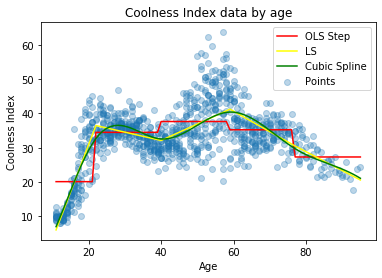

In [19]:
plt.scatter(df2['Age'], df2['Cool'], alpha=0.3, label='Points')
plt.plot(df2['Age'], res.predict(), 'r', label='OLS Step')
plt.plot(df3['Age'], lsq(df3['Age']), 'yellow', label='LS')
plt.plot(df3['Age'], lsq_new(df3['Age']), 'green', label='Cubic Spline')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Index data by age')
plt.show()

In [20]:
print('The predicted coolness of a 73-year old from the step function is', lsq_new(73))

The predicted coolness of a 73-year old from the step function is 32.642301066279764
